In [1]:
!pip install plotly


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import davies_bouldin_score, silhouette_score
import plotly.express as px
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

Loading all the datasets

In [3]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

Feature Engineering

In [5]:
print("Creating features for clustering")

Creating features for clustering


Processing the temporal features

In [6]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
min_date = customers['SignupDate'].min()
customers['account_age_days'] = (customers['SignupDate'] - min_date).dt.days

Creating Transaction based Features

In [7]:
trans_features = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean', 'std'],
    'TransactionDate': ['min', 'max']
}).reset_index()

trans_features.columns = ['CustomerID', 'transaction_count', 
                        'total_value', 'avg_value', 'std_value',
                        'total_quantity', 'avg_quantity', 'std_quantity',
                        'first_purchase', 'last_purchase']

Calculating thr RFM based matrices

In [8]:
current_date = pd.to_datetime(transactions['TransactionDate']).max()
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

rfm = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionID': 'count',  # Frequency
    'TotalValue': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'recency', 'frequency', 'monetary']

Calculating the product category prefernces

In [9]:
trans_products = transactions.merge(products[['ProductID', 'Category']], on='ProductID')
category_pivot = pd.pivot_table(
    trans_products,
    values='TotalValue',
    index='CustomerID',
    columns='Category',
    aggfunc='sum',
    fill_value=0
)

Normalizinfg the category preferences

In [10]:
category_preferences = category_pivot.div(category_pivot.sum(axis=1), axis=0)

Merging all the features

In [11]:
print("Merging features")
customer_features = customers.merge(trans_features, on='CustomerID', how='left')
customer_features = customer_features.merge(category_preferences.reset_index(), on='CustomerID', how='left')
customer_features = customer_features.merge(rfm, on='CustomerID', how='left')

Merging features


Filling the missing values

In [12]:
customer_features = customer_features.fillna(0)

Now we do the feature processing

In [13]:
print("Processing features")

Processing features


Selecting the relevent features for clustering

In [14]:
numeric_features = ['account_age_days', 'transaction_count', 'total_value', 
                   'avg_value', 'std_value', 'total_quantity', 'avg_quantity', 
                   'std_quantity', 'recency', 'frequency', 'monetary']
categorical_features = ['Region']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

Transforming those features

In [15]:
features_processed = preprocessor.fit_transform(customer_features)

In [16]:
print("Determining optimal number of clusters")

Determining optimal number of clusters


Initializing the matrices storage

In [17]:
k_range = range(2, 11)
db_scores = []
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features_processed)
    
    db_scores.append(davies_bouldin_score(features_processed, clusters))
    silhouette_scores.append(silhouette_score(features_processed, clusters))
    inertias.append(kmeans.inertia_)

In [22]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Visualization of the elbow curve

Text(0.5, 1.0, 'Elbow Method')

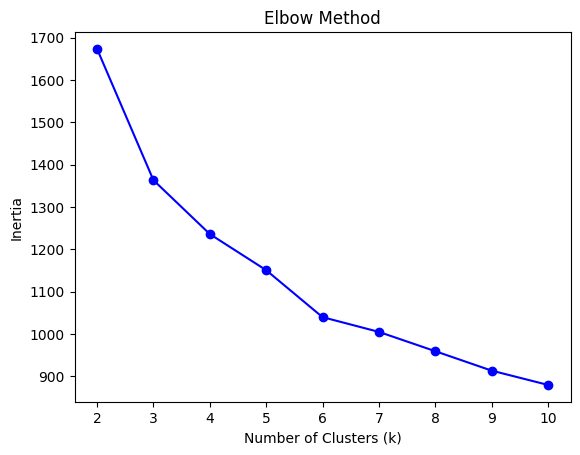

In [24]:

plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')


Visualization of the Davies-Bouldin Score

Text(0.5, 1.0, 'Davies-Bouldin Score')

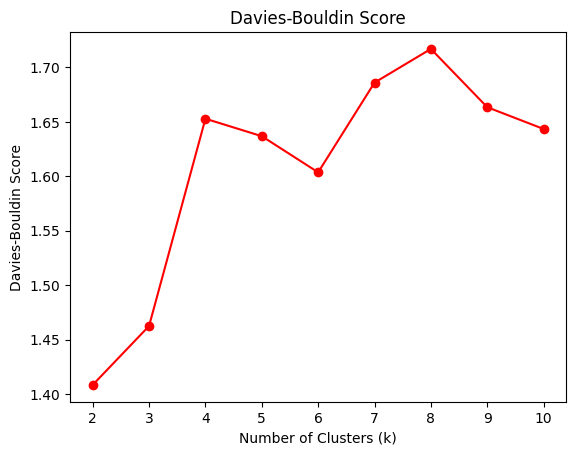

In [25]:
plt.plot(k_range, db_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score')

Visualization of the Silhouette score

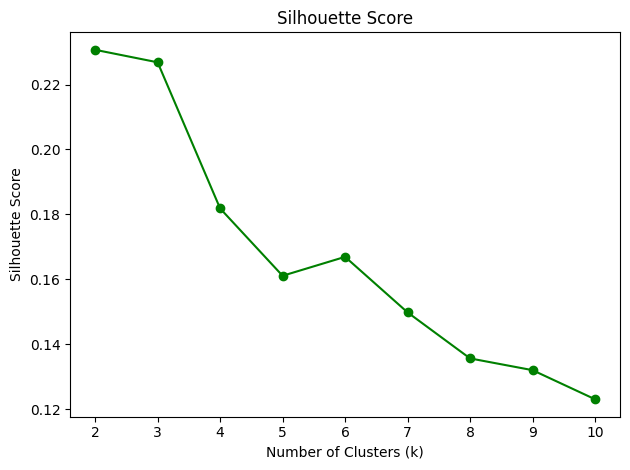

In [27]:
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

Performing Vlustering with optimal number of clusters

In [36]:
optimal_k = k_range[np.argmin(db_scores)]  # Choose based on DB Index
print(f"\nPerforming clustering with {optimal_k} clusters...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features_processed)


Performing clustering with 2 clusters...


Calculation and display of final metrices

In [37]:
final_db_score = davies_bouldin_score(features_processed, customer_features['Cluster'])
final_silhouette = silhouette_score(features_processed, customer_features['Cluster'])

print("\nClustering Results:")
print(f"Number of clusters formed: {optimal_k}")
print(f"Davies-Bouldin Index: {final_db_score:.3f}")
print(f"Other Metrics:")
print(f"- Silhouette Score: {final_silhouette:.3f}")
print(f"- Cluster sizes:")
print(customer_features['Cluster'].value_counts().sort_index())


Clustering Results:
Number of clusters formed: 2
Davies-Bouldin Index: 1.408
Other Metrics:
- Silhouette Score: 0.231
- Cluster sizes:
Cluster
0     72
1    128
Name: count, dtype: int64


Visualizing the clusters using PCA

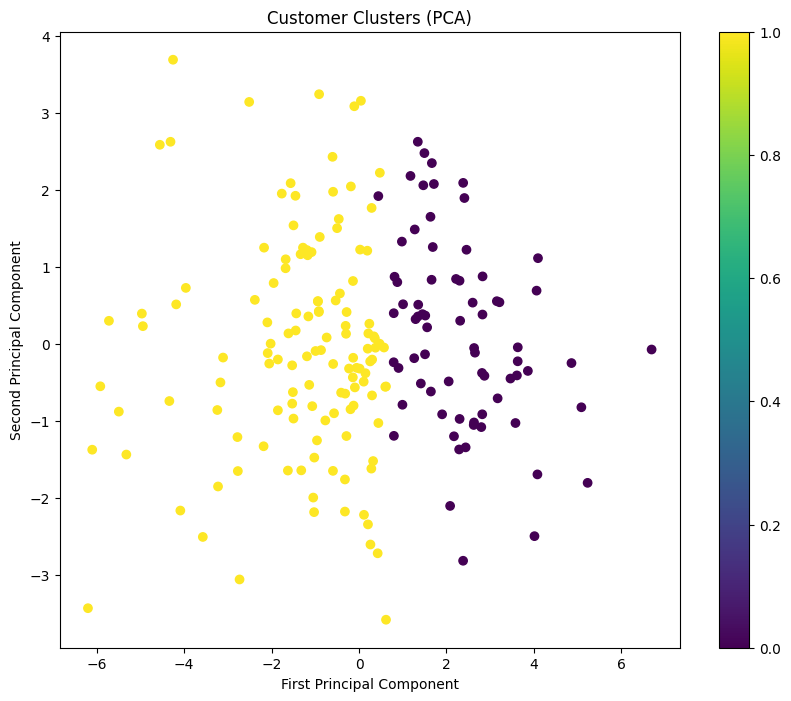

In [30]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_processed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Clusters (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

Visualization of Cluster Characteristics

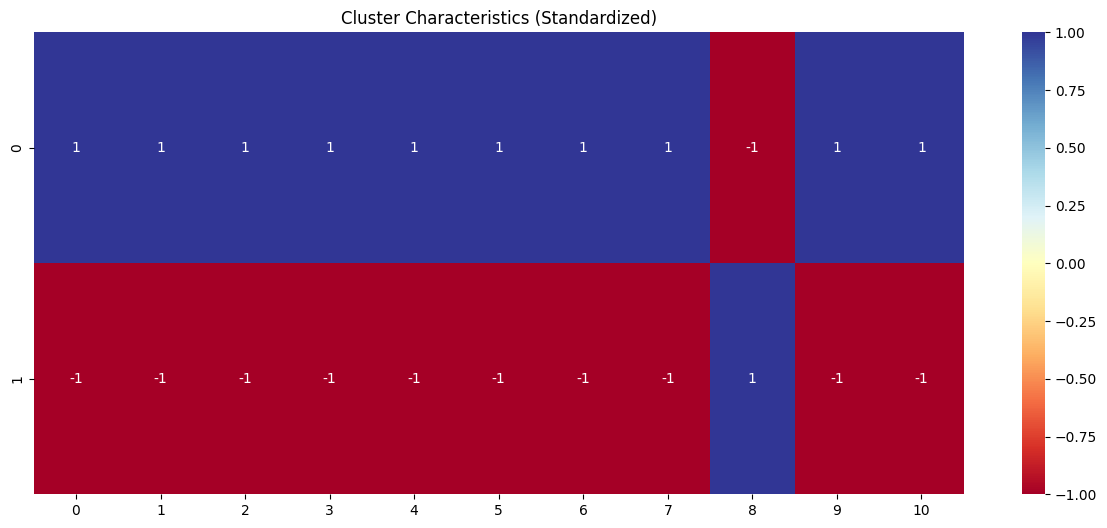


Analysis complete!


In [31]:
cluster_means = customer_features.groupby('Cluster')[numeric_features].mean()
cluster_means_scaled = StandardScaler().fit_transform(cluster_means)

plt.figure(figsize=(15, 6))
sns.heatmap(cluster_means_scaled, annot=True, cmap='RdYlBu', center=0)
plt.title('Cluster Characteristics (Standardized)')
plt.show()

print("\nAnalysis complete!")